In [2]:
import sys
sys.path.append('localmodules')
import joblib
import numpy as np
import pandas as pd
import localmodules.conversor as c
import localmodules.ds_charts as ds
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
#Definição variáveis iniciais
file = 'XAI - Limpo_dummified_smote_minmax.csv'
name = 'XAI - Limpo_dummified_smote_minmax'
tc = 'surgycal margin'
data = pd.read_csv(file,index_col=tc,na_values='',sep=',', decimal='.')
df = pd.DataFrame(data)

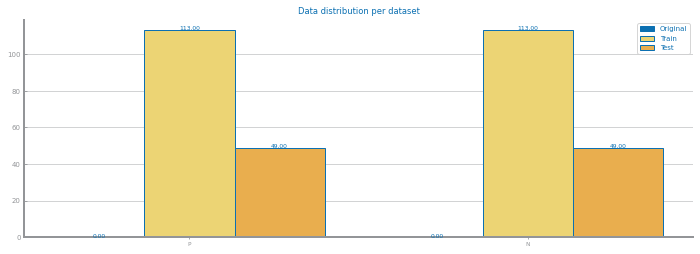

In [4]:
#Separação Teste/Treino
positive = 'P'
negative = 'N'
dataD: pd.DataFrame = pd.read_csv(file)
values = {'Original': [len(dataD[dataD[tc] == positive]), len(dataD[dataD[tc] == negative])]}

y: np.ndarray = dataD.pop(tc).values
X: np.ndarray = dataD.values
labels: np.ndarray = pd.unique(y)
labels.sort()
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = pd.concat([pd.DataFrame(trnX, columns=data.columns), pd.DataFrame(trnY,columns=[tc])], axis=1)
train.to_csv(f'{name}_train.csv', index=False)

test = pd.concat([pd.DataFrame(tstX, columns=data.columns), pd.DataFrame(tstY,columns=[tc])], axis=1)
test.to_csv(f'{name}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

<Figure size 432x288 with 0 Axes>

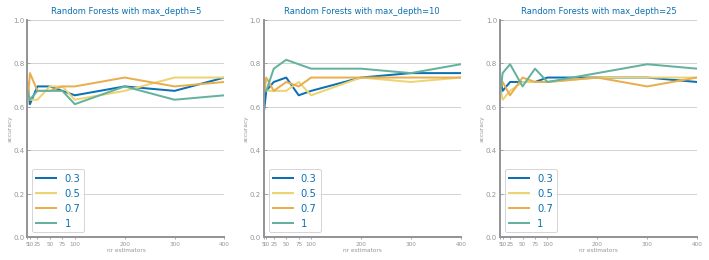

Best results with depth=10, 1.00 features and 50 estimators, with accuracy=0.82


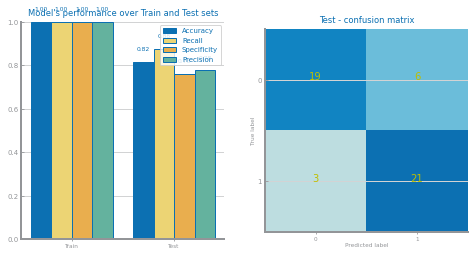

1. feature Prostate.volume (0.147837090452641)
2. feature Capsular.contact.lenght_TLC (0.1277850865174151)
3. feature PSA.value.at.MRI (0.12416222239200865)
4. feature Index.lesion.size (0.11877136148391823)
5. feature Age.at.MRI (0.11566109377385196)
6. feature Capsular.disruption (0.06965855548835873)
7. feature Unsharp.margin (0.04131036607416601)
8. feature ECE.in.prostatectomy.specimen_gold.standard (0.03956921854643344)
9. feature regra (0.03571952480217932)
10. feature Gleason.score (0.028736613481672096)
11. feature Smooth.capsular.bulging (0.027606445022196637)
12. feature Irregular.contour (0.026089908484501326)
13. feature Black.estrition.periprostatic.fat (0.0248363108363456)
14. feature Index.lesion.PIRADS.V2_4 (0.021330105067551744)
15. feature Index.lesion.PIRADS.V2_5 (0.016606187409446624)
16. feature Index.lesion.PIRADS.V2_3 (0.015252854381824119)
17. feature Measurable.ECE (0.013565875817365266)
18. feature Retoprostatic.angle.obliteration (0.00550117996812417)


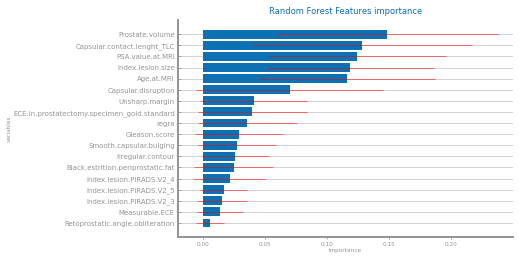

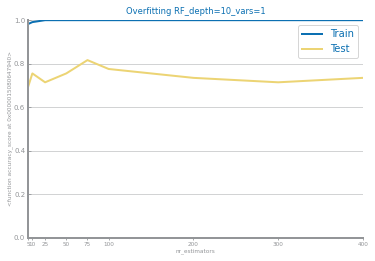

In [6]:
#Random Forests
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
max_features = [.3, .5, .7, 1]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_model = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{name}_rf_study.png')
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

joblib.dump(best_model,'randomforests.joblib')

#Confusion Matrix
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_rf_best.png')
plt.show()

#Feature Importance 
variables = train.columns
importances = best_model.feature_importances_
stdevs = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

plt.figure()
ds.horizontal_bar_chart(elems, importances[indices], stdevs[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
#plt.savefig(f'images/{name}_rf_ranking.png')

#Overfitting Check
f = best[1]
max_depth = best[0]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
    rf.fit(trnX, trnY)
    prd_tst_Y = rf.predict(tstX)
    prd_trn_Y = rf.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
ds.plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'RF_depth={max_depth}_vars={f}', xlabel='nr_estimators', ylabel=str(eval_metric))

In [10]:
#Previsão
#[Age.at.MRI,Prostate.volume,PSA.value.at.MRI,Index.lesion.PIRADS.V2,Index.lesion.size,
# Capsular.contact.lenght_TLC,Smooth.capsular.bulging,Capsular.disruption,Unsharp.margin,
# Irregular.contour,Black.estrition.periprostatic.fat,Retoprostatic.angle.obliteration,
# Measurable.ECE,ECE.in.prostatectomy.specimen_gold.standard,Gleason.score,regra,surgycal margin] L=17
##-----------------------------------------------------------------------------------------------##
#[Age.at.MRI,Prostate.volume,PSA.value.at.MRI,Index.lesion.size,Capsular.contact.lenght_TLC,
# Smooth.capsular.bulging,Capsular.disruption,Unsharp.margin,Irregular.contour,Black.estrition.periprostatic.fat,
# Retoprostatic.angle.obliteration,Measurable.ECE,ECE.in.prostatectomy.specimen_gold.standard,Gleason.score
# regra,Index.lesion.PIRADS.V2_3,Index.lesion.PIRADS.V2_4,Index.lesion.PIRADS.V2_5,surgycal margin] L=19

rfb = joblib.load('randomforests.joblib')

#Conversão -> Transformação valor na posição [3] para 
col = ['Age.at.MRI','Prostate.volume','PSA.value.at.MRI','Index.lesion.size',
       'Capsular.contact.lenght_TLC','Smooth.capsular.bulging','Capsular.disruption','Unsharp.margin',
       'Irregular.contour','Black.estrition.periprostatic.fat','Retoprostatic.angle.obliteration',
       'Measurable.ECE','ECE.in.prostatectomy.specimen_gold.standard','Gleason.score','regra',
       'Index.lesion.PIRADS.V2_3','Index.lesion.PIRADS.V2_4','Index.lesion.PIRADS.V2_5','surgycal margin']
X = [0.444078947,0.2,0.352631579,0.37037037,0.05,0,0,0,0,0,0,0,0,0,1,0,0,1,0]
XX = c.dumm(X)
XXX = c.minmax(XX,data)
XXX.pop(-1)
Y = [XXX]

pred = rfb.predict(Y)
print("Input=%s, Predicted=%s" % (Y, pred))

Input=[[0.444078947, 0.2, 0.352631579, 0.05, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], Predicted=[0]
